# 1. [NNDC_Climate_Data_Online](https://www7.ncdc.noaa.gov/CDO/cdo)

### Abstract

The power consumption behavior for a household is influenced by the weather, in a way that weather signals such as temperature, dew point and pressure might be useful information to model the forecasting. The [**NNDC Climate Data Online**](https://www7.ncdc.noaa.gov/CDO/cdo) is an open platform which provides weather data from many places across the globe. The **IHPC** dataset provides data from a household located in [Sceaux](https://en.wikipedia.org/wiki/Sceaux,_Hauts-de-Seine), a commune in the southern suburbs of Paris, France. There is no data from Sceaux in the NNDC CDO plaform, but there is data available from a close by region, in [Mountsouris, Paris](https://en.wikipedia.org/wiki/Parc_Montsouris). The station is approximately [5.7km from Sceaux](https://www.google.com/maps/dir/Sceaux,+Fran%C3%A7a/48.817,2.333/@48.8185508,2.3069516,14z/data=!4m9!4m8!1m5!1m1!1s0x47e670b58c33d677:0x8f061496b1636438!2m2!1d2.295092!2d48.778016!1m0!3e2).

### Download

In the NNDC CDO platform it's possible to select the country, weather station and the measurements to compose your dataset. The data is then made available in a FTP server for 7 days from where it is possible to download the data.

Link | Description
:---: | :---
http://www.ncdc.noaa.gov/orders/isd/8849028031411dat.txt | DS3505 - Surface Data Hourly Global -  Data File (140176241 bytes)
http://www.ncdc.noaa.gov/orders/isd/8849028031411stn.txt | DS3505 - Surface Data Hourly Global -  Stations included in your search ( bytes)
http://www.ncdc.noaa.gov/orders/isd/8849028031411inv.txt | DS3505 - Surface Data Hourly Global -  Data inventory for your search ( bytes)
http://www.ncdc.noaa.gov/orders/isd/8849028031411doc.txt | DS3505 - Surface Data Hourly Global - format documentation (467837 bytes)

### Data inventory for the search
`
071560 99999 PARIS-MONTSOURIS               2006  725  651  713  703  739  714  714  599  612  738  686  732
071560 99999 PARIS-MONTSOURIS               2007  728  660  720  689  740  711  741  723  705  662  707  743
071560 99999 PARIS-MONTSOURIS               2008  740  683  740  714  738  713  725  728  706  692  706  689
071560 99999 PARIS-MONTSOURIS               2009  718  668  703  718  742  715  743  729  695  740  716  717
071560 99999 PARIS-MONTSOURIS               2010  743  669  730  638  652  713  724  744  716  718  692  718
`


`
Total Surface Hourly Observations Available: 42490
Total Station-Years: 5
`

## 1.1 Download

In [ ]:
!wget -P data/ \
http://www.ncdc.noaa.gov/orders/isd/8849028031411dat.txt

## 1.2. Check Dataset Schema

The head of the file isn't comma separated, therefore it's needed to remove the first 2 lines of the document to be possible to load it to pandas.

In [ ]:
# Print first line to check
!head -1 data/8849028031411dat.txt

In [ ]:
# Remove lines 1 and 2 from the original document and saves to a new file
!sed '1,2 d' data/8849028031411dat.txt > data/nndc_cdo.txt

In [ ]:
import pandas as pd

dataset = pd.read_csv('data/nndc_cdo.txt',
                      sep=",")

In [ ]:
dataset.head()

## 1.3. Selecting features

The features to be used from the NNDC CDO data are:
- **Date** *(Column 3)*: Date in the format YYYYMMDD
- **HrMn** *(Column 4)*: Hour and minute in the format HHMM
- **Temp** *(Column 21)*: Temperature in °C
- **Dewpt** *(Column 23)*: Dew Point in °C



In [ ]:
import pandas as pd

dataset = pd.read_csv('data/nndc_cdo.txt',
                      sep=",",
                      header=None, 
                      usecols=[3,4,21,23],
                      names=['Date','HrMn','Temp','Dewpt'],
                      dtype=object)

In [ ]:
dataset.head()

## 1.4. Load data to postgres

CREATE TABLE statement:

`
CREATE TABLE raw.nndc_cdo (
    _id SERIAL PRIMARY KEY,
    Date TEXT,
    HrMn TEXT,
    Temp TEXT,
    Dewpt TEXT
);`

In [1]:
from os import chdir
chdir('/home/jovyan')

In [2]:
from lib import postgres as pg

In [ ]:
cmd = """
CREATE TABLE raw.nndc_cdo (
    _id SERIAL PRIMARY KEY,
    date TEXT,
    hrmn TEXT,
    temp TEXT,
    dewpt TEXT
);
"""
pg.run_command(cmd)

In [ ]:
pg.bulk_load_df(dataset, 'raw', 'nndc_cdo')

In [ ]:
check = pg.load_query_to_df("""
SELECT main.* FROM
(
SELECT
    *
FROM 
    raw.nndc_cdo
) main
ORDER BY 1 ASC
LIMIT 5;
""")
check.head()

## 1.5. Secting time range

In [ ]:
check = pg.load_query_to_df("""
SELECT main.* FROM
(
SELECT
    max(datetime) as max_datetime,
    min(datetime) as min_datetime
FROM 
    clean.individual_household_power_consumption_h
) main
ORDER BY 1 ASC
LIMIT 5;
""")
check.head()

In [ ]:
features = pg.load_query_to_df("""
SELECT
    clean._id as _id,
    temp.datetime as datetime,
    temp.temperature as temperature,
    temp.dew_point as dew_point
FROM
(
SELECT
    TO_TIMESTAMP(CONCAT(date,' ',hrmn),'YYYYMMDD HH24MISS') as datetime,
    CAST(temp AS FLOAT) as temperature,
    CAST(dewpt AS FLOAT) as dew_point
FROM 
    raw.nndc_cdo
) temp
JOIN
    clean.individual_household_power_consumption_h clean
ON
    temp.datetime = clean.datetime
WHERE temp.datetime between '2006-12-16 17:00:00' AND '2010-11-26 21:00:00'
ORDER BY 1 ASC
LIMIT 5;
""")
features.head()

## 1.6. Load dataset to features schema

CREATE TABLE statement:

`
CREATE TABLE features.IHCPh_weather (
    _id INT PRIMARY KEY,
    datetime TIMESTAMP,
    Temp FLOAT,
    Dewpt FLOAT
);`

In [6]:
cmd = """
CREATE TABLE features.IHCPh_weather (
    _id INT PRIMARY KEY,
    datetime TIMESTAMP,
    temperature FLOAT,
    dew_point FLOAT
);
"""
pg.run_command(cmd)

None


In [3]:
features = pg.load_query_to_df("""
SELECT
    clean._id as _id,
    temp.datetime as datetime,
    temp.temperature as temperature,
    temp.dew_point as dew_point
FROM
(
SELECT
    TO_TIMESTAMP(CONCAT(date,' ',hrmn),'YYYYMMDD HH24MISS') as datetime,
    CAST(temp AS FLOAT) as temperature,
    CAST(dewpt AS FLOAT) as dew_point
FROM 
    raw.nndc_cdo
) temp
JOIN
    clean.individual_household_power_consumption_h clean
ON
    temp.datetime = clean.datetime
WHERE temp.datetime between '2006-12-16 17:00:00' AND '2010-11-26 21:00:00'
ORDER BY 1 ASC
""")
features.head()

,_id,datetime,temperature,dew_point
0,1,2006-12-16 17:00:00+00:00,7.0,4.8
1,2,2006-12-16 18:00:00+00:00,6.9,4.2
2,3,2006-12-16 19:00:00+00:00,6.4,3.7
3,4,2006-12-16 20:00:00+00:00,6.0,4.0
4,5,2006-12-16 21:00:00+00:00,5.6,3.8


In [7]:
pg.bulk_load_df(features, 'features', 'IHCPh_weather')

Connecting to Database
Starting DataFrame CSV export...
CSV File has been created
The table features.IHCPh_weather has been successfully truncated.
It wasn't possible to reset serial _id.
The data has been succesfully loaded to table features.IHCPh_weather
DB connection closed.
Removing temporary files...
Done.
Elapsed time: 0.49625515937805176 seconds


## 1.7 Dealing with missing values

missing_value = 999.9

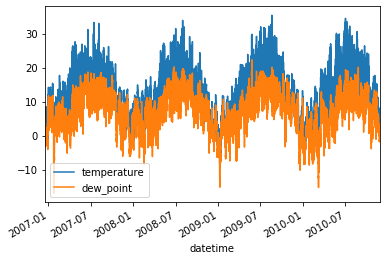

In [78]:
clean = pg.load_query_to_df("""
SELECT
    main._id,
    main.datetime,
    CASE
        WHEN main.temperature > 50 
        THEN (future.temperature + past.temperature)/2
        ELSE main.temperature
    END as temperature,
    CASE
        WHEN main.dew_point > 50
        THEN (past.dew_point + future.dew_point)/2
        ELSE main.dew_point
    END as dew_point
FROM
(
    SELECT
        present._id,
        present.datetime,
        CASE 
            WHEN present.temperature > 50
            THEN (past.temperature + future.temperature)/2 
            ELSE present.temperature 
        END as temperature,
        CASE 
            WHEN present.dew_point > 50 
            THEN (past.dew_point + future.dew_point)/2 
            ELSE present.dew_point 
        END as dew_point
    FROM 
        features.IHCPh_weather present
    LEFT JOIN
        features.IHCPh_weather past
    ON
        present._id = past._id + 1
    LEFT JOIN
        features.IHCPh_weather future
    ON
        present._id = future._id - 1
) main
LEFT JOIN
    features.IHCPh_weather past
ON
    main._id = past._id + 48
LEFT JOIN
    features.IHCPh_weather future
ON
    main._id = future._id - 48
ORDER BY 1 ASC
-- LIMIT 1000
;
""")
plot = clean.set_index('datetime')
plot = plot.drop(columns=['_id'])
plot.plot()

In [79]:
clean.head()

,_id,datetime,temperature,dew_point
0,1,2006-12-16 17:00:00,7.0,4.8
1,2,2006-12-16 18:00:00,6.9,4.2
2,3,2006-12-16 19:00:00,6.4,3.7
3,4,2006-12-16 20:00:00,6.0,4.0
4,5,2006-12-16 21:00:00,5.6,3.8


In [80]:
pg.bulk_load_df(clean, 'features', 'IHCPh_weather')

Connecting to Database
Starting DataFrame CSV export...
CSV File has been created
The table features.IHCPh_weather has been successfully truncated.
It wasn't possible to reset serial _id.
The data has been succesfully loaded to table features.IHCPh_weather
DB connection closed.
Removing temporary files...
Done.
Elapsed time: 0.32807445526123047 seconds
